## Settings for Matroos database

The matroos database is the operational forecasting database of Rijkswaterstaat. Several times a day new forecasts are made with several hydrodynamic (tides and surge) models and wave models. 
The most important models in this context are:
- dd zuno-v4 - this is the current model for the southern North-Sea (available 21-april-2020 until now)
- harmonie - the weather model currently used at KNMI

![dd zunov4](https://matroos.deltares.nl/direct/get_matroos.php?source=dcsmv6_zunov4_zuno_kf_harmonie&color=VELUV_ABS&contour=&anal=&from=202305050900&z=0&xmin=-6&xmax=11.6&ymin=49.2&ymax=57.2&smin=0.000&smax=1&size=640&smincolor=blue&smaxcolor=yellow&coords=WGS84&scontour=&vx=25&vy=25&vecsize=1&xn=1&yn=1&vector=&format=png "Zunv4 model")


In [1]:
# extenal modules
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import getpass


In [2]:
# Settings for Matroos
# use:
# https://matroos.rws.nl if you have an account at that server or
# https://matroos.deltares.nl/ if you have a vpn connection to Deltares or are working in a Deltares office 
database_url = "https://matroos.rws.nl"
print("Enter your Matroos username and password\n")
username = getpass.getpass(prompt="Username:")
password = getpass.getpass(prompt="Password:") #Do not save the password to a public location, such as at github
water_model = "dcsmv6_zunov4_zuno_kf_harmonie"
#print(f'username={username},password={password}')

Enter your Matroos username and password



In [ ]:
# Check the connection to the server
# If you get a data-time for today then everything is working
# There is no need to re-run this cell all the time, since it's just a check

# Download url with get parameters 
url="https://matroos.rws.nl/direct/get_anal_times.php?database=maps2d&loc=&source=dcsmv6_zunov4_zuno_kf_harmonie&unit=&tstart=&tstop=&timezone=&most_recent=5"

# send request to server
r = requests.get(url, auth=(username, password))
print(f'response = {r}  [200 is good]\n')
temp_file = 'temporary_file_with_times.csv'
open(temp_file, 'wb').write(r.content)
# download data into a pandas dataframe
df = pd.read_csv(temp_file, sep=';', index_col=0, parse_dates=True, dayfirst=True)
os.remove(temp_file)
df

In [3]:
# Settings for collecting the data
#initial and final date and time in timezone UTCC (NL winter time is UTC+1, NL summer time is UTC+2)
tstart = "2022-10-01 00:00:00" # start of the period of interest (year-month-day hour:minute:second)
tstop  = "2022-10-02 00:00:00" # end of the period of interest
longitude_min = 4.0 # minimum longitude (most western point in degrees)
longitude_max = 6.0 # maximum longitude (most eastern point in degrees)
latitude_min = 53.0 # minimum latitude (most southern point in degrees)
latitude_max = 54.0 # maximum latitude (most northern point in degrees)
cellx = 100 # number of data points in x-direction (larger will give more detail, but also result in larger files)
celly = 100 # number of data points in y-direction ( you should start carefully with 100, and use an image to check if the data has sufficient detail; see image below)
# The data has the form of a cube with directions x, y and time. The size of the cube is (cellx,celly,ntime) and proportional in filesize to the prduct of these three numbers. For larger values the database will become slower and beyond a certain size it will not respond anymore.


# no need to change anything below this line
fieldoutput="VELU,VELV,VELUV_ABS,SEP" #download these variables (velocity and waterlevel)
stridetime=1 # collect all times or skip some (1 means all times, 2 means every second time, 3 means every third time, etc.)

#reformat time from for example "2022-10-01 00:00:00" to "202210010000"
tstart_str = tstart.replace("-","").replace(" ","").replace(":","")
tstop_str = tstop.replace("-","").replace(" ","").replace(":","")


In [ ]:
# Download the data from the server

#if folder data does not exist, create it
if not os.path.exists("data"):
    os.makedirs("data")

#compose url
url = database_url + "/direct/get_matroos.php?source=" + water_model + "&anal=000000000000&z=0&xmin=" + str(longitude_min) + "&xmax=" + str(longitude_max) + "&ymin=" + str(latitude_min) + "&ymax=" + str(latitude_max) + "&coords=WGS84&xmin_abs=" + str(longitude_min) + "&xmax_abs=" + str(longitude_max) + "&ymin_abs=" + str(latitude_min) + "&ymax_abs=" + str(latitude_max) + "&color=" + fieldoutput + "&interpolate=size&now=" + tstop_str + "&to=" + tstop_str + "&from=" + tstart_str + "&outputformat=nc&stridex=&stridey=&stridetime=" + str(stridetime) + "&xn=" + str(cellx) + "&yn=" + str(celly) + "&celly=" + str(celly) + "&cellx=" + str(cellx) + "&fieldoutput=" + fieldoutput + "&format=nc"
print(f'url={url}\n')
# send request to server
print("Be patient, this can take a while")
r = requests.get(url, auth=(username, password))
print(f'response = {r}  [200 is good]\n')
# save data to file
filename = "data/" + water_model + "_" + tstart_str + "_" + tstop_str + ".nc"
f=open(filename, "wb")
f.write(r.content)
f.close()


Text(0.5, 1.0, 'Currents at time 2022-10-02T00:00:00.000000000')

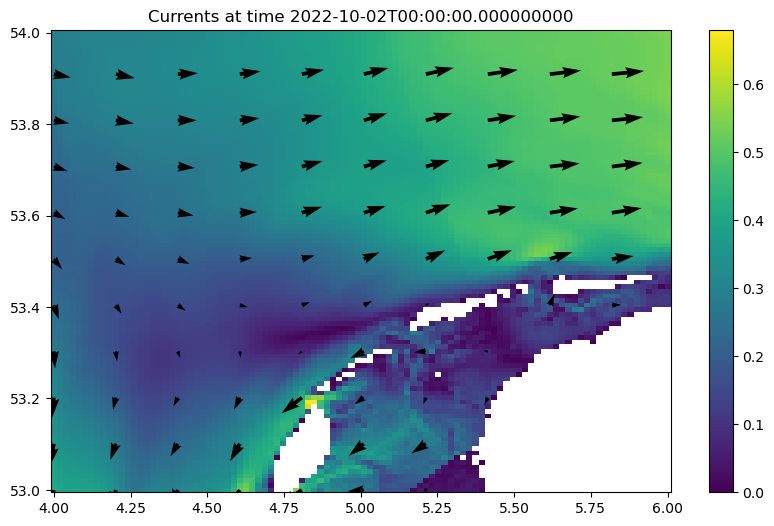

In [4]:
# open data file with xarray
filename = "data/" + water_model + "_" + tstart_str + "_" + tstop_str + ".nc"
ds = xr.open_dataset(filename)
x=ds['x'][:]
y=ds['y'][:]
uv_abs=ds['VELUV_ABS'][-1,:,:]
fig, ax = plt.subplots(figsize=(10, 6))
p1=ax.pcolormesh(x,y,uv_abs) # plot last time step of velocity magnitude
fig.colorbar(p1)
stide=10 # plot every stide-th arrow
ax.quiver(x[::stide],y[::stide],ds['VELU'][-1,::stide,::stide],ds['VELV'][-1,::stide,::stide],scale=10) 
plt.title(f'Currents at time {ds["time"][-1].values}')
#ds 

## Releasing particles in the field

In [ ]:
# Install missing packages on colab (only needed when running on colab)
# remove 'hash comment symbol to activate command
#!pip install parcels cftime netCDF4 cgen zarr Cartopy

In [ ]:
# settings for the particle tracking
filename = "data/" + water_model + "_" + tstart_str + "_" + tstop_str + ".nc"

In [5]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, ScipyParticle, AdvectionRK4, plotTrajectoriesFile
import math
from datetime import timedelta
from operator import attrgetter

In [6]:

# create fieldset (input data for the particle tracking)
variables = {'U': 'VELU',
             'V': 'VELV'}
dimensions = { 'U': {'lat': 'y', 'lon': 'x', 'time': 'time'}, 'V': {'lat': 'y', 'lon': 'x', 'time': 'time'} }
#fieldset = FieldSet.from_netcdf(filename, variables, dimensions, allow_time_extrapolation=True)
fieldset = FieldSet.from_xarray_dataset(ds,variables,dimensions)

# create particles
pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle, # the type of particles (JITParticle or ScipyParticle)
                             lon=[5.0],          # release longitude
                             lat=[53.5],          # release latitude
                             time=[fieldset.U.grid.time[0]]) # release time

# run the particle advection
particle_file=pset.ParticleFile(name="ZUNO_Particles.zarr", outputdt=timedelta(hours=1))
pset.execute(AdvectionRK4,
             runtime=timedelta(days=1),
             dt=timedelta(minutes=5),
             output_file=particle_file
            )

#pset.show()

particle_file.close()

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-1000/lib5abb54a2a3bf4e09d7f08e82ea4a0f69_0.so


In [7]:
plotTrajectoriesFile('ZUNO_Particles.zarr'),
                     #tracerfile=filename,
                     #tracerlon='x',
                     #tracerlat='y',
                     #tracerfield='VELUV_ABS');


/opt64/anaconda3/lib/python3.9/site-packages/parcels/scripts/plottrajectoriesfile.py:41: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  pfile = xr.open_zarr(str(filename), decode_cf=True)
/opt64/anaconda3/lib/python3.9/site-packages/parcels/scripts/plottrajectoriesfile.py:43: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in t

GroupNotFoundError: group not found at path ''

In [8]:
ds_part= xr.open_dataset('ZUNO_Particles.zarr')

/tmp/ipykernel_9354/185346964.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds_part= xr.open_dataset('ZUNO_Particles.zarr')


GroupNotFoundError: group not found at path ''